# 2. Building a simple model

For our first introduction to the Brain Modeling Toolkit (bmtk) and Visual Neuronal Dynamics (vnd) we will start with the simplest network we can think of - a network of just a single cell. Although bmtk and vnd are designed for modeling, simulating and analyzing very large networks, a simple single-cell circuit is still a good way of explaining the functionality of design of these applications.

In later chapters we will show how bmtk and vnd make it easy with little added complexity to go from a simple circuit model of one or two cells, to a more realistic model of thousands or even millions of cells.



In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bmtk.simulator import bionet
from bmtk.builder.networks import NetworkBuilder
from bmtk.utils.create_environment import create_environment
from bmtk.analyzer.spike_trains import plot_raster, to_dataframe
from bmtk.analyzer.compartment import plot_traces


## Choosing your cell models

BMTK has a number of options for which type of cell models to use, for this workshop we will be building networks using models from the Allen Cell-Types database. We can use this to find morphologies and fitted electrophysiological properties for different cells.

Here we want to choose cells that are labeled in the Scnn1a-Tg3-Cre line, which expresses GCaMP6f in [a subset of excitatory neurons in the mouse cortex](http://observatory.brain-map.org/visualcoding/transgenic). For convenience, we've already downloaded the necessary files for this tutorial (available in the _Resources_Ch2_ directory). But if you want to do so manually - or choose different cells - we can use the Allen Cell Types web interface:

### [OPTIONAL] Downloading cells manually

1. Go to the Cell Types database online portal at https://celltypes.brain-map.org/data and go to "Cell Feature Search". Here we want to look for cell models for Scnn1a expressing neurons found in the Mouse L4 area of the Primary Visual Cortex (VISp). 

  Not all cells have models - so it is important to use filter them out using "Models" selection. For our simulations we will be using "Perisomatic Biophysical model" and "GLIF Model" (BMTK will also work with "All-active Biophysical model" but they can be computationally intensive).

<div>
  <img src="../images/ctdb_screenshot.filter_cells.highlighted.png" width="850" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">

2. Choose the cell we want by clicking on "Electrophysiology"

<div>
  <img src="../images/ctdb_screenshot.select_model.highlighted.png" width="850" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">


3. On the Electrophysiology profile page of the cell we can select the type of model using the "Select neuronal model" menu, which will bring up the the option to "Download model" at the bottom of the page. In this case we want a model type "Biophysical - perisomatic". Clicking "Download model" will download the model files as a zip file.

<div>
  <img src="../images/ctdb_screenshot.ephys_page.highlighted.png" width="850" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">

4. The two main files we want from the zip are *fit_parameters.json* containing electrophysiology parameters, and *reconstruction.swc* containing the morphological reconstruction of the cell. Since we will eventually be working with multiple models, let's rename these files to something more descriptive and move them to a different directory. 
    

Alternatively, we could use the AllenSDK to filter and download cell model files. See [AllenSDK](https://allensdk.readthedocs.io/en/latest/) for detailed documentation.

## Building a Single Cell Model

Although BMTK was designed to allow for large-scale heterogenous networks, we will first use it to create and simulate a network consisting of just a single cell. We will be using model files downloaded from the Allen Cell Types Database. 

To build a network we can use the BMTK Network Builder module to build and save the SONATA network files. 

It is a good idea to remove any old files in the *network/* directory otherwise it might cause the following error when running the notebooks:

<div class="alert alert-block alert-danger">
<b>OSError<b>: Unable to create file (unable to truncate a file which is already open)
</div>
    
You can remove the files using the command line:
```bash
  $ rm -r network
```
or with the following code:

In [2]:
for f in glob.glob('network/*'):
    try:
        os.remove(f)
    except FileNotFoundError as fnfe:
        pass

<div class="alert alert-block alert-info">
<b>Tip</b>: If you wish to run this tutorial from scratch, delete everything <b>except</b> the IPython notebook and the <i>Resources_Ch2/</i> directory. However, if you do so, you will need to repopulate the components directory with the dynamic parameter, morphology, and mechanism files from <i>Resources_Ch2/</i> according to the detailed directions.
</div>

<div class="alert alert-block alert-info">
<b>Tip</b>: There is a small amount of biologically relevant randomness built into the models and simulation, so everytime the notebook is run it is expected to get different results. However should you want to match the same results with the "completed" version of the tutorials please use the rng seed below:
</div>

In [3]:
np.random.seed(100)

In [4]:
from bmtk.builder.networks import NetworkBuilder

scnn1a = NetworkBuilder('cell')
scnn1a.add_nodes(
    # required
    N=1,
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    model_processing='aibs_perisomatic',
    dynamics_params='Scnn1a_485510712_params.json',
    morphology='Scnn1a_485510712_morphology.swc',
    
    # optional
    ei_type='exc',
    model_name='Scnn1a',
    species='mouse',
    location='VISp',
    layer='L4'
)
scnn1a.build()
scnn1a.save(output_dir='network')

If you encounter the exception "File network/cell_nodes.h5 already exists", please delete all the contents of the _/network_ directory as described above.

When run, this will create a network called "cell" into the _network_ directory. 

Some properties of the add_nodes() method are required to run the simulation in BioNet. We set __N__ to 1 to indicate we are only building one Scnn1a-type cell. __model_type__, __model_template__, and __model_processing__ are all directives telling BMTK to create a biophysically detailed perisomatic Allen-Institute cell model. Lastly __dynamics_params__ and __morphology__ are the files containing the cell's electrophysiological and morphological properties, respectively.

SONATA also gives us the option of adding properties to our network. __ei_type__, __model_name__, __location__, etc. are properties that will be ignored by the simulator, but can potentially be useful for human-readablity and future data analysis.

### Setting up the environment

Now that we have the SONATA network files complete, we need to set up the workspace to allow us to run the simulation.

In [5]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'bionet',
    base_dir='.',                      # Where to save the scripts and config files
    config_file='config.iclamp.json',  # 
    network_dir='network',             # Location of directory containing network files
    output_dir='output_iclamp' ,       # Directory where simulation output will be put into
    tstop=3000.0, dt=0.1,              # Run a simulation for 2000 ms at 0.1 ms intervals
    current_clamp= {
        'amp': 0.150,                  # Current size (pA)
        'delay': 500,                  # Time from start of simulation to onset of step (ms)
        'duration': 2000               # Duration of current step (ms)
    },
    report_vars=['v'],                 # Record membrane potential
    compile_mechanisms=True,           # Try to compile NEURON mechanisms
    # overwrite=True,                  # Overwrite pre-existing config files of same name, default is False
)

ERROR:root:Configuration file /home/ping/bmtk_workshop/bmtk_workshop_2022/Ch2_single_cell/config.iclamp.json already exists, skipping. Please delete existing file, use a different name, or use overwrite=True.


/home/ping/bmtk_workshop/bmtk_workshop_2022/Ch2_single_cell/components/mechanisms
Mod files: "modfiles/CaDynamics.mod" "modfiles/Ca_HVA.mod" "modfiles/Ca_LVA.mod" "modfiles/Ih.mod" "modfiles/Im.mod" "modfiles/Im_v2.mod" "modfiles/Kd.mod" "modfiles/K_P.mod" "modfiles/K_T.mod" "modfiles/Kv2like.mod" "modfiles/Kv3_1.mod" "modfiles/Nap.mod" "modfiles/NaTa.mod" "modfiles/NaTs.mod" "modfiles/NaV.mod" "modfiles/SK.mod" "modfiles/vecevent.mod"

COBJS=''
 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Or also do the same in the command-line:
```bash
  $ python -m bmtk.utils.create_environment        \
                 --config-file config.iclamp.json  \
                 --overwrite                       \
                 --network-dir network             \
                 --output-dir output_iclamp        \
                 --tstop 3000.0                    \
                 --dt 0.1                          \
                 --report-vars v                   \
                 --iclamp 0.150,500,2000           \
                 --compile-mechanisms              \
                 bionet .
```

If you get ```Arg Error: "modfiles" is not a folder or mod file name or prefix```, **copy the *modfiles* folder containing the NEURON .mod files (located in *Resources_Ch2*) into *components/mechanisms/* and rerun**.

**If working from scratch, add the electrophysiology params file into _components/biophysical_neuron_models/_, the morphology .swc file into _components/morphologies/_, and the hoc templates into _components/templates_.**

If you do not delete the existing config files, you will get a warning indicating that these files have not been overwritten. For the purposes of this tutorial, that is okay as we are just remaking the same files.

After running this, your directory structure should look like the following.

<div>
    <img src="../images/bmtk_workspace_setup.png" width="650" align="left"/>    
</div>

Let's take a look at the configuration JSON files that were created and see how we could edit them directly. 

##### config.iclamp.json

Opening up the config file in a text editor we can see it consists of sections:

```json
{
  "manifest": {
    "$BASE_DIR": "${configdir}",
    "$NETWORK_DIR": "$BASE_DIR/network",
    "$COMPONENTS_DIR": "$BASE_DIR/components",
    "$OUTPUT_DIR": "$BASE_DIR/output_iclamp"
  },
  "components": {
    "templates_dir": "$COMPONENTS_DIR/templates",
    "synaptic_models_dir": "$COMPONENTS_DIR/synaptic_models",
    "biophysical_neuron_models_dir": "$COMPONENTS_DIR/biophysical_neuron_models",
    "morphologies_dir": "$COMPONENTS_DIR/morphologies",
    "mechanisms_dir": "$COMPONENTS_DIR/mechanisms",
    "filter_models_dir": "$COMPONENTS_DIR/filter_models",
    "point_neuron_models_dir": "$COMPONENTS_DIR/point_neuron_models"
  },
  "networks": {
    "nodes": [
      {
        "node_types_file": "$NETWORK_DIR/cell_node_types.csv",
        "nodes_file": "$NETWORK_DIR/cell_nodes.h5"
      }
    ],
    "edges": [],
    "gap_juncs": []
  }
}
```

* The "__networks__" section points to the location on the disk of all the SONATA nodes and edges files that we will be using. The model we have just built using the NetworkBuilder currently only consists of a single node (i.e., cell) which was saved in the _network/_ folder.


* The "__components__" section is where we set the location of any external files - including the Cell-Type database electrophysiology and morphology files. For this simulation the relevant components include:
  * biophysical_neuron_models_dir: directory containing any **dynamics_params** files used to build the individual cell models
  * morphologies_dir: directory containing any swc or other morphology files BMTK will require to build the cells
  * mechanisms_dir: This is where we can put any extra compiled mechanisms that are required by the NEURON simulator. The Allen Cell-Type models require some voltage-gated channel mechanisms that must be precompiled and loaded into NEURON before running. If the appropriate *.mod files are placed in _mechanisms/modfiles/_, BMTK  will compile the mechanisms for us when using the setting ```compile_mechanisms=True``` in ```bmtk.utils.create_environment```. Otherwise, we would need to run the following: 
  ```bash
  $ cd components/mechansims
  $ nrnivmodl modfiles
  ```
  * filter_models_dir and point_neuron_models_dir: For other types of networks (FilterNet and PointNet), not used in this tutorial.


Next we have the simulation sections of the config which is where we can set the main parameters for running individual simulations. It too can be broken down into a number of different parts:

* The "__run__" and "__conditions__" sections contain basic information including for how long we want to run the simulation (*tstop*, in ms), the time steps (_dt_), maximum NEURON compartment size (_dL_, in um) and the threshold at which NEURON will recognize a spike (_spike_threshold_, in mV) and other conditions. 

```json
  "target_simulator": "NEURON",
  "run": {
    "tstart": 0.0,
    "tstop": 3000.0,
    "dt": 0.1,
    "dL": 20.0,
    "spike_threshold": -15.0,
    "nsteps_block": 5000
  },
  "conditions": {
    "celsius": 34.0,
    "v_init": -80.0
  },
```
 
The _nsteps_block_ parameter determines the interval (in time-steps) at which intermediate results are calculated and saved. This will not affect the results but can affect time and memory efficiency of simulation.


* The "__output__" and "__reports__" sections are where we specify which parameters from the simulation are recorded and where on the disk the results are stored. 
  By default BMTK will record and save spikes to the specified "spikes_files" into "output_dir". For other types of recording we can add one or more subsection to "__reports__". For example, if we wanted to be able to record the membrane potential, or "v" variable, from our cell's soma, we could add a report section as the following:

``` json
  "output": {
    "log_file": "log.txt",
    "output_dir": "$OUTPUT_DIR",
    "spikes_file": "spikes.h5"
  },
  "reports": {
    "v_report": {
      "variable_name": "v",
      "cells": "all",
      "module": "membrane_report",
      "sections": "soma"
    }
  },
```

  Alternatively, we can specify this when we first set up the simulation with ```bmtk.utils.create_environment``` (as was done above), which assigns it the name "v_report".
  
  * "module" parameter is used to indicate what type of SONATA report is being recorded, in this case a report on one or more membrane variables. "variable_name" is used to specify what variable is being recorded.
  * The "cells" section is used to indicate what subset of cells we want to record from. Here we are using the reserved "all" designator to record from all possible cells. We could also pass a dictonary of key/value pairs to filter
 ```json
   "cells": {"ei_type": 'excitatory', 'location': 'VISp'}
 ```
   or we can pass in a list of node_ids
 ```json
   cells: [0]
 ```
 Of course for our network with only one cell all the above options will produce the same results.

 
* The "__inputs__" section is where we specify the inputs we want to use to drive the simulation. Instead of specifying the current clamp with ```bmtk.utils.create_environment``` as above, we could have alternatively directly added the following section to the simulation config to provide a current clamp (aka IClamp) into the soma of our cell:

``` json
  "inputs": {
    "current_clamp": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "gids": "all",
      "amp": 0.15,
      "delay": 500,
      "duration": 2000
    }
  },
```
  * "input_type" and "module" parameters indicate the type of input BMTK will produce
  * "node_set" refers to the subset of nodes we want to apply the current-clamp to. The "all" keyword will be used to apply input to all cells in network. As above we could also pass in a list of node_ids ```"node_set": [0]``` or even a set of conditions ```node_set: {"ei_type": "excitatory"}``` to filter which cells receive the current clamp.
  * "delay", "duration" and "amp" are used to specify the timing and amplitude of the stimulus. In this case we are applying a 0.150 nA pulse starting at 500 ms and lasting for 2000 ms.
  
  We can also run a simulation with multiple inputs, including the same or different types of inputs. For example to run increasing current impulses in series we would update the "__inputs__" section as following:
```json
  "inputs": {  
    "cclamp_weak": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.01,
      "delay": 100.0,
      "duration": 900.0
    },  
    "cclamp_medium": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.200,
      "delay": 1100.0,
      "duration": 900.0
    }, 
    "cclamp_strong": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": "all",
      "amp": 0.900,
      "delay": 2100.0,
      "duration": 900.0
    }
```

### Use VND to examine the 3D structure of the model described in the JSON configuration file.

Launch VND by typing `vnd` on the Linux command line.

In the Visual Neuronal Dynamics window select, select menu item  **File : Open File**
and choose the file `Ch2_single_cell/config.iclamp.json`.



You should see the default "soma" view, a single sphere, since this is a single cell model.

In the VND Main tab, there should be one item in the list of representations. Change the representational style from
**Style:Soma**
to
**Style:Morphology**
to see the biophysical detail of the cell.

Explore the cell morphology with zooming, rotation, and translation:

- press **s** (scale mode), click left mouse button and drag left/right to scale 
- press **t** (translate mode) to move left and right up and down: click left mouse button and drag
- press **r** (rotation mode) to return to rotation mode: click left mouse button and drag
- in all modes, rotate the mouse wheel to scale up/down, as if in **s** (scale mode)

<div>
  <img src="../images/ch2_iclamp_morphology.png" width="805" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">



### Running a simulation

Now that we have built our network and set up our configuration we are ready to run our simulation. This can be done in a terminal or IDE using the "run_bionet.py" script created for us:

```bash
$ python run_bionet.py config.iclamp.json
```

or in the notebook:


In [6]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('config.iclamp.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2022-11-21 11:30:07,419 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2022-11-21 11:30:07,488 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-11-21 11:30:07,547 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-11-21 11:30:07,553 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.100 ms


2022-11-21 11:30:07,555 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-11-21 11:30:07,556 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-11-21 11:30:07,824 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2022-11-21 11:30:08,015 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2022-11-21 11:30:08,232 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2022-11-21 11:30:08,421 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2022-11-21 11:30:08,692 [INFO]     step:25000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms


2022-11-21 11:30:08,977 [INFO]     step:30000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms


2022-11-21 11:30:08,994 [INFO] Simulation completed in 1.441 seconds 


INFO:NEURONIOUtils:Simulation completed in 1.441 seconds 


As specified in *simulation_config_iclamp.json*, BMTK was instructed to create reports for spike trains (default) as well as the membrane potential from the soma (in the "__reports__" section). We can use BMTK's analyzer module to display these for our one cell with node id 0.

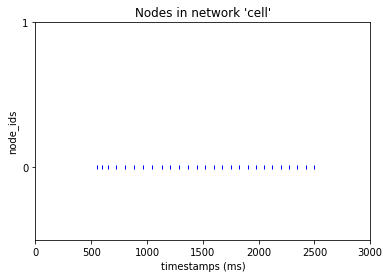

In [7]:
from bmtk.analyzer.spike_trains import plot_raster, to_dataframe

_ = plot_raster(config_file='config.iclamp.json', with_histogram=False)

In [8]:
to_dataframe(config_file='config.iclamp.json')

,timestamps,node_ids,population
0,551.1,0,cell
1,2346.7,0,cell
2,2272.7,0,cell
3,2198.5,0,cell
4,2124.3,0,cell
5,2049.9,0,cell
6,1975.3,0,cell
7,1900.5,0,cell
8,1825.4,0,cell
9,1750.1,0,cell


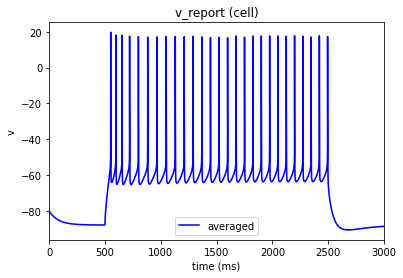

In [9]:
from bmtk.analyzer.compartment import plot_traces

_ = plot_traces(config_file='config.iclamp.json', report_name='v_report')

## Simulation with Synaptic Stimulation

Stimulation with current clamp can provide useful information on the core electrophysiological profile of cells. However, if we are going to fit our cells into a large connected network we will want to show how the cell behaves when more realistic synaptic inputs are given to the cell.

The easiest way to drive a cell, or network, with synaptic stimulation is to use "virtual" type cells. Virtual cells do not have any electrophysiological or morphological properties, and are essentially just placeholders for spike-trains or currents. However, they can create feed-forward synapses.

Luckily, we can add virtual cells to our model and simulation without having to rebuild the network. BMTK and SONATA allows for different populations of a network to be built independently and connected together in the config. So to add synaptic stimuli using virtual cells we will do the following:
1. Create a new network of virtual cells that synapse onto our existing Scnn1a model.
2. Generate spikes for our virtual cells.
3. Update the configuration files.
4. Rerun the simulation.



### Creating the network

As before we will use the network builder to create a new population of cells we will call "virt_exc". We will create 20 different "virt_exc" type cells by using the ```N=20``` option. 

And unlike biophysically detailed cells we don't need to specify dynamics_params, model_template, model_processing or morphology. All we need to do is specify that ```model_type='virtual'```.

In [10]:
virt_exc = NetworkBuilder('virt_exc')
virt_exc.add_nodes(
    N=20,
    model_type='virtual',
    ei_type='exc'
)

Next we want to create edges/synapses from our virtual cells onto our Scnn1a cells using the ```add_edges()``` method.

In [11]:
import numpy as np
from bmtk.builder.bionet import rand_syn_locations


conns = virt_exc.add_edges(
    source=virt_exc.nodes(),
    target=scnn1a.nodes(),
    connection_rule=12,
    model_template='Exp2Syn',
    dynamics_params='AMPA_ExcToExc.json',
    delay=2.0,
    syn_weight=0.004
)

conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['soma', 'basal', 'apical'], 
        'distance_range': [0.0, 1.0e20],
        'morphology_dir': 'components/morphologies' 
    },
    dtypes=[int, float, int, float]

)

virt_exc.build()
virt_exc.save(output_dir='network')


First the ```add_edges()``` method is called which can create different edge types based on the following parameters:

* __source__ and __target__ are used to determine what subset of cells will be used as the pre- and post-synaptic neurons. By indicating virt_exc.nodes() we are saying that the source/pre-synaptic neurons for these types of edges are all "virt_exc" nodes. Similarly scnn1a.nodes() indicates we want to use all (i.e., the only) neuron in the scnn1a network. 

  We could also add key-value pairs to get a subset of the neurons for these edge-types. For example we could explicitly state we want only to connect to excitatory L4 neurons by setting ```target=scnn1a.nodes(ei_type='exc', layer='L4')```. Of course with only one cell-type in our population it will still produce the same results.
 
 
* __connection_rule__ is used to indicate the number of connections between each neuron in our source and target subsets. By passing in ```connection_rule=12``` we are telling the Builder that every source cells has 12 individual synapses onto every target cell. Later we will show how to pass in customized functions or lists to fine tune the rules of connectivity.


* __model_template__ is used to indicate the NEURON synapse model, in this case an [Exp2Syn](https://www.neuron.yale.edu/neuron/static/new_doc/modelspec/programmatic/mechanisms/mech.html#Exp2Syn) model. __dynamics_params__ for the synapse, like for neurons, contains the property values for our synapse type. The location of synaptic dynamics param files are set using the "synaptic_models_dir" option in the config file. 


* __syn_weight__ and __delay__ are properties of this synaptic type.

After using ```add_edges()``` to create shared properties that will apply to all connections of this edge-type, we have the option of using ```add_properties()``` to add individual synaptic properties. In this case we want to specify the location of the individual synapses along our Scnn1a cell's morphology.

Here we are using the ```rand_syn_locations``` function, built into the BMTK Builder, to randomly select locations of each synapse based on the criteria set in __rule_params__ - which indicates we want any section (soma, apical dendrites, basal dendrites) at any distance (arc-length from soma in um). This function will add the section and position properties to the SONATA edges file so both BMTK and VND can pin-point the simulation.

Finally, we call ```build()``` and ```save()``` which will create new nodes and edges files to the _network/_ directory


Let us also create another network of virtual nodes, but this time of inhibitory inputs. This will look the same but for connections we will alter it so that:
1. For the **connection_rule** in ```add_edges()``` we will randomized the number of connections between each source and target neuron.
2. In ```add_properties()``` we will prevent synapses being located near the soma.


In [12]:
virt_inh = NetworkBuilder('virt_inh')
virt_inh.add_nodes(
    N=30,
    model_type='virtual',
    ei_type='inh'
)

conns = virt_inh.add_edges(
    source=virt_inh.nodes(),
    target=scnn1a.nodes(),
    connection_rule=lambda src, trg: np.random.randint(0, 25),
    model_template='Exp2Syn',
    dynamics_params='GABA_InhToExc.json',
    delay=2.0,
    syn_weight=0.008
)

conns.add_properties(
    ['afferent_section_id', 'afferent_section_pos', 'afferent_swc_id', 'afferent_swc_pos'],
    rule=rand_syn_locations,
    rule_params={
        'sections': ['basal', 'apical'], 
        'distance_range': [20.0, 1.0e20],
        'morphology_dir': 'components/morphologies' 
    },
    dtypes=[int, float, int, float]
)

virt_inh.build()
virt_inh.save(output_dir='network')


**At this point we need to add the synaptic model parameter files into _components/synaptic_models/_.**

### Use VND to examine the synapses in this model

Launch VND by typing `vnd` on the Linux command line.

In the Visual Neuronal Dynamics window select, select menu item  **File : Open File with Edges**
and choose the file `Ch2_single_cell/config.with_syns.json`.



You should see the default "soma" view, a single sphere, since this is a single cell model.

In the VND Main tab, there should be one item in the list of representations. Change the representational style from
**Style:Soma**
to
**Style:Morphology**
to see the biophysical detail of the cell.

Explore the cell morphology with zooming, rotation, and translation.

Add the synapse locations for this cell:

In the VND Connectivity tab:
set 
- Source: all (either select the existing "all" selection from the pop-up list, or type "all")
- Target: all
- Color: red
- Style: source_sphere_swc
and click "Create Connection Rep"

 then set:
 
- Source: all
- Target: all
- Color: green 
- Style: target_sphere_swc
and click "Create Connection Rep"

You should see the synapse target locations as red spheres, and the soma as a green sphere.  In this model, the cell soma is a potential "source", but only in the context of other cells, not to elsewhere in the same cell.  In the below image, a 100 micron bar is added for scale.

Explore the synapse locations with zooming, rotation, and translation.


<div>
  <img src="../images/ch2_simple_edge_swc_c_micron_scale__source_swc_red_target_swc_red.png" width="805" align="left" style="margin-left:26px"/>    
</div>
<br clear="left">

### Generating spike trains

As mentioned virtual cells are just placeholders, most commonly for pre-generated spike trains. To activate the network we must create spikes we can assign to our virtual cells by creating a SONATA spike-trains file. There are a number of ways to do this in bmtk, the easiest is to use the built-in ```PoissonSpikeGenerator```.

The following will create a spike-train file for our "virt_exc" cells. For each cell in our "virt_exc" nodes file we will randomly generate a series of action-potentials firing at a rate of 15.0 Hz for 3 seconds, then save it to the _inputs/_ directory.


In [13]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

psg = PoissonSpikeGenerator()
psg.add(
    node_ids='network/virt_exc_nodes.h5', 
    firing_rate=20.0, 
    times=(0.0, 3.0),
    population='virt_exc'
)
psg.to_sonata('inputs/virt_exc_spikes.h5')

The ```PoissonSpikeGenerator``` can also use variable firing rates, for example for the inhibitory virtual nodes the firing rate will be determined as a sine wave over the period of the simulation (make sure that firing-rate is always >= 0.0 otherwise an error will be thrown).

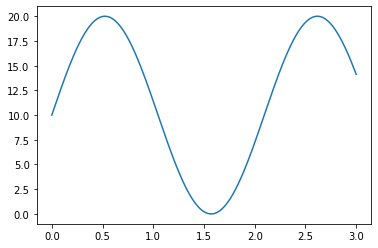

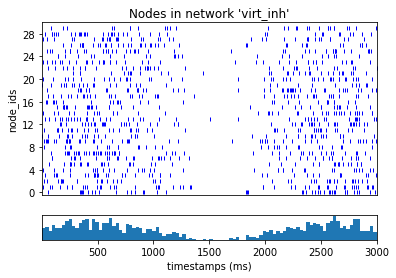

In [14]:
import matplotlib.pyplot as plt

times = np.linspace(0.0, 3.0, 1000)
rates = 10*np.sin(times*3) + 10


psg = PoissonSpikeGenerator()
psg.add(
    node_ids='network/virt_inh_nodes.h5', 
    firing_rate=rates, 
    times=times,
    population='virt_inh'
)
psg.to_sonata('inputs/virt_inh_spikes.h5')

# plot the firing rates
plt.plot(times, rates)

_ = plot_raster(spikes_file='inputs/virt_inh_spikes.h5')

Another option for generating spikes manually is to use the ```bmtk.utils.reports.spike_trains.SpikeTrains``` class. For example pseudo code may look something like the following - but filling in the actual spike times yourself:

```python
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes_writer = SpikeTrains()
for node_id in node_ids:
    spikes_writer.add_spikes(node_ids=node_id, timestamps=[...], population='virt_exc')
spikes_writer.to_sonata('inputs/virt_exc_spikes.h5')
```

Alternatively, since SONATA spike train files are the same for input spikes as they are for outputs, one could use the output of one network simulation as the input to another. Indeed we will be using FilterNet for such a purpose later in the course.


### Updating the configurations

We've previously created the SONATA configuration file _config.iclamp.json_ that contains all the necessary paths and directives to run a simulation containing only the single "cell" population being stimulated by a series of current clamps. Now we want a single another config file that contains the **virt_exc** and **virt_inh** populations, their synaptic connections, and the spike-trains files we generated above. 

One option is to make a copy of _config.iclamp.json_ and update it accordingly as shown below. 

Or we can call the ```bmtk.utils.create_environment``` functionality as we did previously - but this time making sure we save the **config-file=config.with_syns.json**:

In [15]:
from bmtk.utils.create_environment import create_environment

create_environment(
    'bionet',
    base_dir='.',
    network_dir='network',      
    output_dir='output_syns',
    config_file='config.with_syns.json',
    overwrite=True,
    tstop=3000.0, dt=0.1,  
    report_vars=['v'], 
    spikes_inputs=[
        ('virt_inh', 'inputs/virt_inh_spikes.h5'),
        ('virt_exc', 'inputs/virt_exc_spikes.h5')
    ],
    compile_mechanisms=True,
    run_script='run_bionet.syns.py'
)

/home/ping/bmtk_workshop/bmtk_workshop_2022/Ch2_single_cell/components/mechanisms
Mod files: "modfiles/CaDynamics.mod" "modfiles/Ca_HVA.mod" "modfiles/Ca_LVA.mod" "modfiles/Ih.mod" "modfiles/Im.mod" "modfiles/Im_v2.mod" "modfiles/Kd.mod" "modfiles/K_P.mod" "modfiles/K_T.mod" "modfiles/Kv2like.mod" "modfiles/Kv3_1.mod" "modfiles/Nap.mod" "modfiles/NaTa.mod" "modfiles/NaTs.mod" "modfiles/NaV.mod" "modfiles/SK.mod" "modfiles/vecevent.mod"

COBJS=''
 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Or also do the same in the command-line:
```bash
  $ python -m bmtk.utils.create_environment                                                             \
                 --config-file config.with_syns.json                                                    \
                 --overwrite                                                                            \
                 --network-dir network                                                                  \
                 --output-dir output_syns                                                               \
                 --tstop 3000.0                                                                         \
                 --dt 0.1                                                                               \
                 --report-vars v                                                                        \
                 --spikes-inputs virt_inh:inputs/virt_inh_spikes.h5,virt_exc:inputs/virt_exc_spikes.h5  \
                 --compile-mechanisms                                                                   \
                 bionet .
```

The main difference between the two above calls to ```create_environment``` is that 
1. We change the name of the *config_file* options so we can use either one, config.iclamp.json or config.with_syns.json, without having to overwrite them.
2. We also change the *output_dir* so that the different simulations are saving results to different directories. With this it would overwrite the previous results each time we reran a simulation.
3. Initially we use the *current_clamp* option which will edit the "inputs" section of the config with a iclamp with parameters specified in the dictionary. In the second simulation config we don't use current-clamps. Instead we pass in a list of spike trains with value (\<population_name>, \<spikes_file_path>).

We can open up *config.with_syns.json* file with any text editor to see the major differences:


As we can see in the "networks" section, our "nodes" include the SONATA nodes files for the "**cell**", "**virt_inh**" and "**virt_exc**" population of nodes. And in the "edges" section it includes **virt_ext** --> **cell** and **virt_inh** --> **cell** synapses.
```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/virt_inh_nodes.h5",
        "node_types_file": "$NETWORK_DIR/virt_inh_node_types.csv"
      },
      {
        "node_types_file": "$NETWORK_DIR/virt_exc_node_types.csv",
        "nodes_file": "$NETWORK_DIR/virt_exc_nodes.h5"
      },
      {
        "node_types_file": "$NETWORK_DIR/cell_node_types.csv",
        "nodes_file": "$NETWORK_DIR/cell_nodes.h5"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/virt_inh_cell_edges.h5",
        "edge_types_file": "$NETWORK_DIR/virt_inh_cell_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/virt_exc_cell_edges.h5",
        "edge_types_file": "$NETWORK_DIR/virt_exc_cell_edge_types.csv"
      }
    ]
  }

```


In the "inputs" section of the configuration, we have two "spikes" inputs types which will indicate to bmtk (or any other SONATA compliant application) to use the spike train files associated with the **virt_exc** and **virt_inh** nodes to drive input to the network.
```json
  "inputs": {
    "exc_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "./inputs/virt_exc_spikes.h5",
      "node_set": "virt_exc"
    },
    "inh_spikes": {
      "input_type": "spikes",
      "module": "sonata",
      "input_file": "./inputs/virt_inh_spikes.h5",
      "node_set": "virt_inh" 
    }
  },

```

Lastly the output_dir is updated so that results are saved into the *output_syns* folder

```json
  "output": {
    "log_file": "log.txt",
    "output_dir": "./output_syns",
    "spikes_file": "spikes.h5"
  },
```


Finally we can run the simulation as before in the command line:

```bash
$ python run_bionet.py config.with_syns.json
```

or by running the following: 

In [16]:
# Will reset BioNet and the NEURON simulator. Required if we want
# to run the simulator multiple times in the same notebook.
bionet.reset()

In [17]:
from bmtk.simulator import bionet

conf = bionet.Config.from_json('config.with_syns.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2022-11-21 11:30:11,424 [INFO] Created log file


INFO:NEURONIOUtils:Created log file
NEURON: The user defined name already exists: CaDynamics
 near line 0
 {create axon[2]}
                 ^
        nrn_load_dll("/home/ping...")


2022-11-21 11:30:11,444 [WARNING] Unable to load NEURON mechanisms.


2022-11-21 11:30:11,519 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-11-21 11:30:11,598 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-11-21 11:30:11,601 [INFO] Building virtual cell stimulations for virt_inh_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for virt_inh_spikes


2022-11-21 11:30:11,672 [INFO] Building virtual cell stimulations for virt_exc_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for virt_exc_spikes


2022-11-21 11:30:11,722 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.100 ms


2022-11-21 11:30:11,723 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-11-21 11:30:11,724 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-11-21 11:30:12,139 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2022-11-21 11:30:12,432 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2022-11-21 11:30:12,767 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2022-11-21 11:30:13,077 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2022-11-21 11:30:13,427 [INFO]     step:25000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms


2022-11-21 11:30:13,784 [INFO]     step:30000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms


2022-11-21 11:30:13,795 [INFO] Simulation completed in 2.073 seconds 


INFO:NEURONIOUtils:Simulation completed in 2.073 seconds 


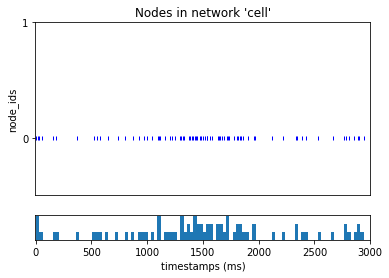

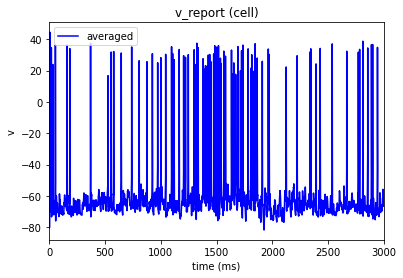

In [18]:
from bmtk.analyzer.spike_trains import plot_raster
from bmtk.analyzer.compartment import plot_traces

_ = plot_raster(config_file='config.with_syns.json')
_ = plot_traces(config_file='config.with_syns.json', report_name='v_report')


## Up Next

We have shown you the basics of building, simulating and analyzing the simplest network we can have in bmtk. Next, we will show how to scale up to a multi-cell and multi-cell-type network using the same API calls we have used, and how bmtk will handle the technical difference between simple and complex network generation and simulation, so you can focus more on the modeling.

[**Proceed to Chapter 3**](../Ch3_multicells/3.%20Multipopulation%20biophysical.ipynb)


## [OPTIONAL]: Reports Formats Deep Dive

The following will provide deeper insight on the two SONATA output formats that we worked with in this tutorial: the spike train reports and the membrane potential reports. We'll quickly go over their formats, and how to read/write them using BMTK and with pure Python. For further information see the [SONATA specification](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#output-file-formats).



### SONATA Spike format

SONATA spike files are an hdf5-based format for storing the action-potentials/spike times of cells within a network. We can use a tool like [HDFView](https://www.hdfgroup.org/downloads/hdfview/) or [ViTables](https://vitables.org/) to open up the hdf5 file and see the overview:

<br>
<div>
  <img src="../images/spikes_file_h5.png" width="600" align="left" style="margin-left:15px"/>    
</div>
<br clear="left">

* SONATA files with spike trains will start with path /spikes/$<$population$>$/, where $<$population$>$ is the name of a population of nodes (i.e., cells). There may be more than one population in the spikes. 
* Then we have tables **node_ids** and **timestamps**, both having the same number of entries, and each row indicates a time (by default in ms from start) at which a specific node generated an action-potential.
* The spikes and nodes may or may not be sorted. There is an optional attribute "sorting" which developers can use to determine if the spikes are unsorted (sorting=none), sorted by node_ids (sorting=by_id) or by time (sorting=by_time).

#### Reading and Writing SONATA spikes

BMTK includes a package ```bmtk.utils.reports.spike_trains.SpikeTrains``` which can be used to read and write spike-files. 

Here we can use it to load in the "virt_exc_spikes.h5" 

In [19]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains.load('inputs/virt_exc_spikes.h5')

# Get properties of virt_exc spikes
print(' populations: ', spikes.populations)
print('total spikes: ', spikes.n_spikes(population='virt_exc'))
print('    node-ids: ', spikes.node_ids(population='virt_exc'))
print()

# Get the timestamps at which node 10 fired
print('node_id 10 spike times: ', spikes.get_times(node_id=10, population='virt_exc'))
print()

# Get spikes as a dataframe
spikes_df = spikes.to_dataframe(population='virt_exc')
print(spikes_df.head())


 populations:  ['virt_exc']
total spikes:  1197
    node-ids:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

node_id 10 spike times:  [  35.07277258   35.58062092   58.80508281  168.78515489  196.5912301
  201.36937915  247.13673733  266.86077028  301.99439742  322.01401708
  382.05672152  396.5506169   409.39551992  418.49746347  428.21567122
  435.0610742   435.97578628  486.83858557  487.62495964  614.98906313
  675.52156683  677.52611259  732.08354251  821.89151404  826.92114703
  848.04190074  942.5049713  1240.0489211  1370.37774336 1377.14401953
 1403.24197688 1420.26832038 1574.11116688 1577.34717218 1685.40328464
 1708.41561548 1774.3552349  1996.71824328 2061.76997028 2146.59538778
 2177.62256217 2356.30850965 2409.53101913 2487.46238547 2604.26127157
 2633.65994348 2816.31917711 2818.20740993 2832.65690185 2900.73840113
 2955.84003114]

   timestamps  node_ids population
0   18.651334         0   virt_exc
1   68.687096         0   virt_exc
2  128.779004     

If you would prefer to not use BMTK:

In [20]:
import h5py
import pandas as pd

with h5py.File('inputs/virt_exc_spikes.h5', 'r') as h5:
    spikes_df = pd.DataFrame({
        'node_ids': h5['/spikes/virt_exc/node_ids'][()],
        'timestamps': h5['/spikes/virt_exc/timestamps'][()]
    })
    print(spikes_df.head())
    

   node_ids  timestamps
0         0   18.651334
1         0   68.687096
2         0  128.779004
3         0  180.135223
4         0  306.436520


Writing SONATA spikes file can also be done using ```SpikeTrains```

```python
from bmtk.utils.reports.spike_trains import SpikeTrains

# Create a SpikeTrains instance. We can pass in parameter "population" once during the construction
#  rather than at every method call like we did above.
spikes = SpikeTrains(population='my_pop')

# We can add a single spike
spikes.add_spike(node_id=0, timestamp=1.0)

# We can add a list of spikes for a single node
spikes.add_spikes(node_ids=0, timestamps=[2.0, 3.0, 4.0])

# Or we can add multiple spikes for multiple nodes
spikes.add_spikes(node_ids=[1, 1, 2, 3], timestamps=[0.5, 0.9, 1.0, 1.0])

# We will save it to SONATA, and we can also save it to a CSV file
spikes.to_sonata('my_pop_spikes.h5')
spikes.to_csv('my_pop_spikes.csv')
```

### SONATA Compartmental report format

The compartmental report (aka frame-oriented report) can be used to store membrane and intracellular variables like membrane voltage, caTium concentration, or any variable that is constantly updated at each time-step of the simulation. It can store the time-trace of the variable for one or more cells. And for multi-compartment type cell models it can store the time-traces for any or all compartments belonging to said cell.

As before we can open up the file in HDFView or ViTables:

<br>
<div>
  <img src="../images/compart_report_overview.png" width="850" align="left" style="margin-left:15px"/>    
</div>
<br clear="left">


* Like with spikes, we expect to see a hdf5 path starting with /report/$<$population$>$, where $<$population$>$ is the name of a population of nodes.
* The variable traces are saved in the "data" table orient by $T \times C$, where $T$ is the number of time-steps and $C$ the number of cells/compartments.
* ./mapping/ path contains a number of different metadata we can use to better parse the "data" table
  * "time" is a size $T$ list which contains the actual time-stamps of each step in the simulation.
  * "element_ids" and "element_pos" are size $C$ and contain the compartment identifier plus the position in the compartment where the recording was taken.
  * "node_ids" and "index_pointer" are used to map each compartment to its cell's node_id
  <!-- ![](../images/segmentation_indexing.jpg) -->

<br>
<div>
  <img src="../images/segmentation_indexing.jpg" align="left" style="margin-left:25px"/>    
</div>
<br clear="left">



### Reading and Writing SONATA Compartment Reports

We can use BMTK's  ```bmtk.utils.reports.compartment.CompartmentReport``` to read the data of a compartment report.


In [21]:
from bmtk.utils.reports.compartment import CompartmentReport

# Open report
vm_report = CompartmentReport.load('./output_syns/v_report.h5')
print('Recorded cell populations:', vm_report.populations)
print('            Variable name:', vm_report.variable(population='cell'))
print('                 node_ids:', vm_report.node_ids(population='cell'))
print('                    times:', vm_report.tstart(population='cell'), vm_report.tstop(population='cell'), vm_report.dt(population='cell'))
print()

# Let us find all the compartment and record positions for node 0 
print(' section_id:', vm_report.element_ids(node_id=0, population='cell'))
print('section_pos:', vm_report.element_pos(node_id=0, population='cell'))
print('          V:', vm_report.data(node_id=0, population='cell').T)


Recorded cell populations: ['cell']
            Variable name: v
                 node_ids: [0]
                    times: 0.0 3000.0 0.1

 section_id: [0]
section_pos: [0.5]
          V: [[-80.03813815 -80.06109322 -80.07905331 ... -66.0360917  -65.89278802
  -65.59816002]]


We can also write data to a SONATA Compartment Report.

In [22]:
import numpy as np
from bmtk.utils.reports.compartment import CompartmentReport

recorder = CompartmentReport('my_compartment_report.h5', mode='w', default_population='my_pop')

# We need to first set global properties for timesteps as well as the variable name
recorder.set_tstart(0.0)
recorder.set_tstop(5.0)
recorder.set_dt(1.0)
recorder.set_variable('my_var')

# First we must add information about each node/cell, including the compartments that are 
#  being recorded for each cell
recorder.add_cell(node_id=0, element_ids=list(range(0, 10)), element_pos=[0.5]*10)
recorder.add_cell(node_id=1, element_ids=list(range(0, 3)), element_pos=[0.5]*3)

# We can record the variable at each time step
for ts in [0, 1, 2, 3, 4]:
    recorder.record_cell(node_id=0, vals=[0.0]*10, tstep=ts)

# Or we can save it in blocks
mdata = np.full((5, 3), fill_value=1.0)
recorder.record_cell_block(node_id=1, vals=mdata, beg_step=0, end_step=5)

recorder.close()
